In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import sparse

from pynufft import NUFFT_cpu

import pylops

# Description of the matrix approach 

For real data we solve the system

$\left[ \tilde{f}^T \tilde{f} + R^T T \right] x = \tilde{f}^T y$

where $\tilde{f} = D f$ is a real matrix of shape ($n_p$, $n_s$). $f$ is a real matrix of shape ($n_p$, $n_s$) and $D$ is the convolution which is a real matrix of shape ($n_p$, $n_p$).

$------------------------------------$

For complex data we instead solve the system

$\left[ \tilde{f_{\Re}}^T \tilde{f_{\Re}} + \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right] x = \tilde{f_{\Re}}^T y_{\Re} + \tilde{f_{\Im}}^T y_{\Im}$

where $\tilde{f} = D f$ is a compex matrix of shape ($n_v$, $n_s$). $f$ is a real matrix of shape ($n_p$, $n_s$) and $D$ is the non-uniform fast fourier transform (NUFFT) which is a complex matrix of shape ($n_v$, $n_p$).

$\textbf{Note}$ that since we require the solution to be real the following inequality holds

$ (\tilde{f_{\Re}}^T \tilde{f_{\Re}})^{-1} \tilde{f_{\Re}}^T y_{\Re} \ne (\tilde{f_{\Im}}^T \tilde{f_{\Im}})^{-1} \tilde{f_{\Im}}^T y_{\Im}$

In our matrix approach (for complex data), regularization is applied after we sum the real and imag components

$\left[ \left(\tilde{f_{\Re}}^T \tilde{f_{\Re}} + \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right) + R^T R \right] x = \tilde{f_{\Re}}^T y_{\Re} + \tilde{f_{\Im}}^T y_{\Im}$

$------------------------------------$

To summarize, in our matrix approach, the solution $x$ is always real as the matrix inversion is performed with "real" matrices, which have been constructed from the sum of the real and imag compponents of a originaly complex matrix.

| Object | Dimension | type | Description |
|------|------|------|------|
|   $n_v$  | - | - | # of visibilities |
|   $n_p$  | - | - | # of image-plane pixels |
|   $n_s$  | - | - | # of source-plane pixels |
|------|------|------|
|   $f$  | $(n_p, n_s)$ | real | mapping matrix |
|   $D$  | $(n_v, n_p)$ | complex | non-uniform fast fourier transform (NUFFT) |
|   $\tilde{f}$  | $(n_v, n_s)$ | complex | NUFFT'd mapping matrix |

# Pylops 

In [64]:
def NormalEquationsInversion_with_real_and_imag_Ops(
    Op_real, 
    Op_imag, 
    data_real, 
    data_imag, 
    returninfo=False, 
    **kwargs_cg
):

    OpH_real = Op_real.H
    OpH_imag = Op_imag.H

    Op_normal_real = OpH_real * Op_real
    Op_normal_imag = OpH_imag * Op_imag
    Op_normal = (Op_normal_real + Op_normal_imag)

    y_normal_real = OpH_real * data_real
    y_normal_imag = OpH_imag * data_imag
    y_normal = y_normal_real + y_normal_imag

    xinv, istop = sparse.linalg.cg(Op_normal, y_normal, **kwargs_cg)

    if returninfo:
        return xinv, istop
    else:
        return xinv
    
    
def NormalEquationsInversion(
    Op, 
    data, 
    returninfo=False, 
    **kwargs_cg
):

    OpH = Op.H

    Op_normal = OpH * Op

    y_normal = OpH * data

    xinv, istop = sparse.linalg.cg(Op_normal, y_normal, **kwargs_cg)

    if returninfo:
        return xinv, istop
    else:
        return xinv

In [65]:
class D_Op(NUFFT_cpu, pylops.LinearOperator):
    def __init__(self, uv, shape_2d, reshaping_x=True):
        super(D_Op, self).__init__()

        self.u, self.v = uv.T

        om = np.array([self.u, self.v]).T
        
        self.shape_2d = shape_2d

        self.plan(
            om=om,
            Nd=self.shape_2d,
            Kd=(
                int(2 * self.shape_2d[0]),
                int(2 * self.shape_2d[1])
            ),
            Jd=(6, 6),
        )

        n_p = int(self.shape_2d[0] * self.shape_2d[1])

        self.shape = (uv.shape[0], n_p)
        self.dtype = "complex128"
        self.explicit = False
        
        self.reshaping_x = reshaping_x
        
    def reshape_x(self, x):
        return x.reshape(self.shape_2d)

    def forward_lop(self, x):
        # NOTE: Takes an "image" (array) of shape (n, n) and performs the non-uniform 
        # fast fourier transform resulting in a complex matrix of length n_v.
        
        # NOTE: The array that is passed was flattened so we reshape it to the shape (n, n)
        # that NUFFT requires. The array "x" is real as it represents an image.
        if self.reshaping_x:
            x = self.reshape_x(x=x)
            
        y = self.k2y(self.xx2k(self.x2xx(x)))

        return y

    def adjoint_lop(self, y):

        x = self.xx2x(self.k2xx(self.y2k(y)))

        return x

    def _matvec(self, x):
        return self.forward_lop(x)

    def _rmatvec(self, x):
        return self.adjoint_lop(x)
    
    
class D_Op_real(D_Op):
    
    def forward_lop(self, x):
        
        if self.reshaping_x:
            x = self.reshape_x(x=x)
            
        y = self.k2y(self.xx2k(self.x2xx(x)))

        return np.real(y)

    def adjoint_lop(self, y):

        x = self.xx2x(self.k2xx(self.y2k(y)))

        return np.real(x)
    

class D_Op_imag(D_Op):
    
    def forward_lop(self, x):
        
        if self.reshaping_x:
            x = self.reshape_x(x=x)
            
        y = self.k2y(self.xx2k(self.x2xx(x)))

        return np.imag(y)

    def adjoint_lop(self, y):

        x = self.xx2x(self.k2xx(self.y2k(y)))

        return np.imag(x)

# Tools

## general

In [2]:
def a_complex_from_a_real_and_a_imag(
    a_real, 
    a_imag
):
    # NOTE: Convert a numpy array of shape (n, 2) to a complex array of shape (n, )

    a_complex = np.stack(
        arrays=(a_real, a_imag), axis=-1
    )

    a_complex = np.apply_along_axis(
        lambda args: [complex(*args)], len(a_complex.shape) - 1, a_complex
    ).astype("complex128")

    return np.squeeze(a_complex)

In [3]:
# NOTE: Make a "random" sparse matrix (with 0's & 1's)
def random_sparse_matrix(n_p, n_s):

    def nonzero_to_ones(a):

        a[np.where(a > 0.0)] = 1.0

        return a

    f_obj = sparse.random(
        m=n_p, n=n_s
    )

    return nonzero_to_ones(
        a=f_obj.A
    )

In [4]:
def reshape(a, shape_2d):

    return a.reshape(shape_2d)

## visualization

In [89]:
def plot_1_to_1_from_x(x):
    
    x_min = np.min(x)
    x_max = np.max(x)
    
    plt.plot(
        np.linspace(x_min, x_max, 10),
        np.linspace(x_min, x_max, 10),
        linestyle="--",
        color="black"
    )

In [5]:
def add_colorbar_to_axes(figure, im, axes):

    cax = make_axes_locatable(
        axes
    ).append_axes('right', size='5%', pad=0.05)

    figure.colorbar(
        im,
        cax=cax,
        orientation='vertical'
    )

In [51]:
def visualize_f(f, shape_2d, nrows, ncols, figsize):

    if nrows * ncols < f.shape[-1]:
        raise ValueError("")
        
    figure, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=figsize
    )

    k = 0
    for i in range(nrows):
        for j in range(ncols):

            f_k = f[:, k]

            f_k_reshaped = reshape(
                a=f_k, shape_2d=shape_2d
            )

            axes[i, j].imshow(f_k_reshaped)

            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            k += 1
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

# Examples

## Example 1

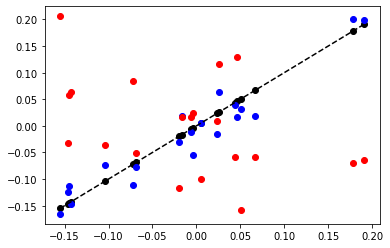

In [94]:
N_vis = 100
N_grid = 400
N_src = 20

#f_real = np.random.normal(0.0, 1.0, size=(N_grid, N_src))
#f_imag = np.random.normal(0.0, 1.0, size=(N_grid, N_src))

f_tilde_real = np.random.normal(0.0, 1.0, size=(N_vis, N_src))
f_tilde_imag = np.random.normal(0.0, 1.0, size=(N_vis, N_src))

F_real = np.dot(f_tilde_real.T, f_tilde_real)
F_imag = np.dot(f_tilde_imag.T, f_tilde_imag)

d_real = np.random.normal(0.0, 1.0, size=(N_vis, ))
d_imag = np.random.normal(0.0, 1.0, size=(N_vis, ))

D_real = np.dot(f_tilde_real.T, d_real)
D_imag = np.dot(f_tilde_imag.T, d_imag)

# NOTE: This is the linear system Ax = y we are solving in our matrix approach.
x = np.linalg.solve(
    F_real + F_imag, 
    D_real + D_imag
)

# NOTE: For real-world applications D_real != D_imag & F_real != F_imag, therefore there is not
# a single "real" vector x that satisfies both systems (this is in respose to https://github.com/PyLops/pylops_notebooks/blob/master/developement/ComplexMatmul.ipynb). 
x_real = np.linalg.solve(F_real, D_real)
x_imag = np.linalg.solve(F_imag, D_imag)

# ------------------ 
# NOTE: Method 1
# ------------------ 

f_tilde_real_lops = pylops.MatrixMult(f_tilde_real, dtype='float64')
f_tilde_imag_lops = pylops.MatrixMult(f_tilde_imag, dtype='float64')

x_lops_method_1 = NormalEquationsInversion_with_real_and_imag_Ops(
    Op_real=f_tilde_real_lops,
    Op_imag=f_tilde_imag_lops,
    data_real=d_real,
    data_imag=d_imag
)

# ------------------ 
# NOTE: Method 2
# ------------------

f_tilde_complex = a_complex_from_a_real_and_a_imag(
    a_real=f_tilde_real, 
    a_imag=f_tilde_imag
)
f_tilde_complex_lops = pylops.MatrixMult(
    f_tilde_complex, dtype="complex128"
)

d_complex = a_complex_from_a_real_and_a_imag(
    a_real=d_real, a_imag=d_imag
)

x_lops_method_2 = NormalEquationsInversion(
    Op=f_tilde_complex_lops,
    data=d_complex
)

# ------------------ 
# visualization
# ------------------ 

plt.figure()
plt.plot(x, x_lops_method_1, linestyle="None", marker="o", color="black")
plt.plot(x, x_lops_method_2.real, linestyle="None", marker="o", color="b")
plt.plot(x, x_lops_method_2.imag, linestyle="None", marker="o", color="r")
#plt.plot(x_real, x_lops_method_2.real, linestyle="None", marker="s", color="b")
#plt.plot(x_imag, x_lops_method_2.imag, linestyle="None", marker="s", color="r")
x_min = np.min(x)
x_max = np.max(x)
plt.plot(
    np.linspace(x_min, x_max, 10),
    np.linspace(x_min, x_max, 10),
    linestyle="--",
    color="black"
)
plt.show()

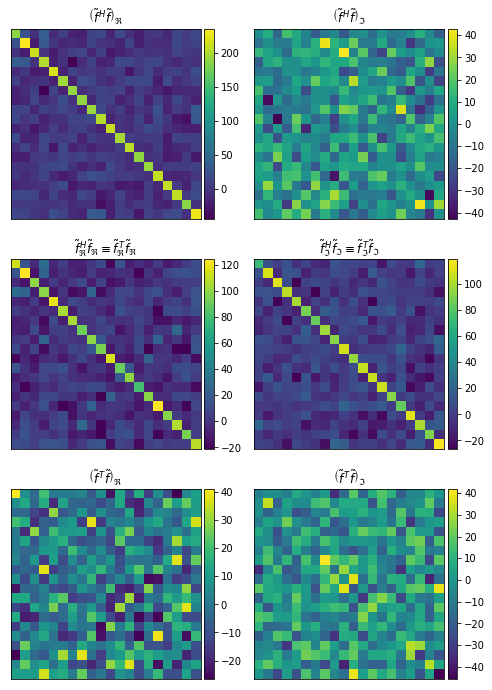

In [93]:
prod_f_tilde_complex_H = np.dot(
    f_tilde_complex.conj().T, 
    f_tilde_complex
)
prod_f_tilde_complex_T = np.dot(
    f_tilde_complex.T, 
    f_tilde_complex
)

figure, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(8, 12)
)

im00 = axes[0, 0].imshow(prod_f_tilde_complex_H.real)
im01 = axes[0, 1].imshow(prod_f_tilde_complex_H.imag)
im10 = axes[1, 0].imshow(np.dot(f_tilde_real.conj().T, f_tilde_real))
im11 = axes[1, 1].imshow(np.dot(f_tilde_imag.conj().T, f_tilde_imag))
im20 = axes[2, 0].imshow(prod_f_tilde_complex_T.real)
im21 = axes[2, 1].imshow(prod_f_tilde_complex_T.imag)

add_colorbar_to_axes(figure=figure, im=im00, axes=axes[0, 0])
add_colorbar_to_axes(figure=figure, im=im01, axes=axes[0, 1])
add_colorbar_to_axes(figure=figure, im=im10, axes=axes[1, 0])
add_colorbar_to_axes(figure=figure, im=im11, axes=axes[1, 1])
add_colorbar_to_axes(figure=figure, im=im20, axes=axes[2, 0])
add_colorbar_to_axes(figure=figure, im=im21, axes=axes[2, 1])

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

axes[0, 0].title.set_text(r"$\left( \tilde{f}^{\, H} \tilde{f} \right)_{\Re}$")
axes[0, 1].title.set_text(r"$\left( \tilde{f}^{\, H} \tilde{f} \right)_{\Im}$")
axes[1, 0].title.set_text(r"$\tilde{f}_{\Re}^{\, H} \tilde{f}_{\Re} \equiv \tilde{f}_{\Re}^{\, T} \tilde{f}_{\Re}$")
axes[1, 1].title.set_text(r"$\tilde{f}_{\Im}^{\, H} \tilde{f}_{\Im} \equiv \tilde{f}_{\Im}^{\, T} \tilde{f}_{\Im}$")
axes[2, 0].title.set_text(r"$\left( \tilde{f}^{\, T} \tilde{f} \right)_{\Re}$")
axes[2, 1].title.set_text(r"$\left( \tilde{f}^{\, T} \tilde{f} \right)_{\Im}$")

plt.show()

## Example 2

In [70]:
n_v = 100 # NOTE: n_v is the # of visibilities

# NOTE: Non-uniform points in the uv-space
u = np.random.uniform(-1.0, 1.0, n_v)
v = np.random.uniform(-1.0, 1.0, n_v)

uv = np.stack(
    arrays=(u, v), axis=-1
)

In [71]:
n_s = 20  # NOTE: n_s is the # of source-plane pixels

shape_2d = (20, 20)
n_p = int(shape_2d[0] * shape_2d[1]) # NOTE: n_p is the # of image-plane pixels

In [72]:
f = random_sparse_matrix(
    n_p=n_p, n_s=n_s
)

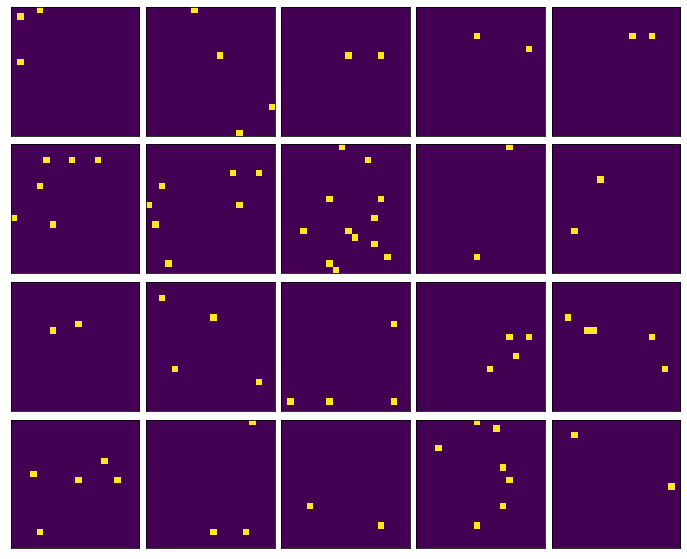

In [73]:
visualize_f(
    f=f, shape_2d=shape_2d, nrows=4, ncols=5, figsize=(12, 10)
)

Define the non-uniform fast fourier transform operator, $D$.

In [74]:
Dop = D_Op(uv=uv, shape_2d=shape_2d)

In the $\textbf{Matrix Formalism}$ we need to explicitly construct the matrix $\tilde{f}$ which is a very expensive operation. For real-world problem $n_v$ is of the order of $\sim 10^{9} - 10^{12}$ limiting us not only in terms of run times but also in memory usage. The goal with the Pylops approach is to express $\tilde{f}$ as a linear Operator utilizing the fact that $f$ is sparse.

In [75]:
# NOTE: Construct the $\tilde{f}$ matrix
f_tilde = np.zeros(
    shape=(n_v, n_s), dtype="complex"
)
for i in range(f.shape[-1]):
    f_tilde[:, i] = Dop.forward_lop(x=f[:, i])

f_tilde_real = f_tilde.real
f_tilde_imag = f_tilde.imag

$\textbf{Matrix Formalism:}$ Solve the system $\left( \tilde{f}^T_{\Re} \tilde{f}_{\Re} + \tilde{f}^T_{\Im} \tilde{f}_{\Im} \right) x = \tilde{f}^T_{\Re} y_{\Re} + \tilde{f}^T_{\Im} y_{\Im}$

In [80]:
F_real = np.dot(f_tilde_real.T, f_tilde_real)
F_imag = np.dot(f_tilde_imag.T, f_tilde_imag)

y_real = np.random.normal(0.0, 1.0, size=(n_v, ))
y_imag = np.random.normal(0.0, 1.0, size=(n_v, ))

D_real = np.dot(f_tilde_real.T, y_real)
D_imag = np.dot(f_tilde_imag.T, y_imag)

x = np.linalg.solve(
    F_real + F_imag,
    D_real + D_imag
)

x_real = np.linalg.solve(F_real, D_real)
x_imag = np.linalg.solve(F_imag, D_imag)

$\textbf{Pylops Formalism:}$

In [77]:
# NOTE: This is the current version of our Pylops formalism. It gives us a complex solution
# which is not what we want.
f_lops = pylops.MatrixMult(
    sparse.bsr_matrix(f), dtype='float64'
)

Op = Dop * f_lops

data = a_complex_from_a_real_and_a_imag(
    a_real=d_real, a_imag=d_imag
)

x_lops = NormalEquationsInversion(
    Op=Op, data=data
)

$\textbf{Pylops Formalism:}$

In [78]:
# NOTE: This is the modified version of our Pylops formalism, which is still not right
Dop_real = D_Op_real(uv=uv, shape_2d=shape_2d)
Dop_imag = D_Op_imag(uv=uv, shape_2d=shape_2d)

Op_real = Dop_real * f_lops
Op_imag = Dop_imag * f_lops

x_lops_with_real_and_imag_Ops = NormalEquationsInversion_with_real_and_imag_Ops(
    Op_real=Op_real, 
    Op_imag=Op_imag, 
    data_real=d_real, 
    data_imag=d_imag, 
)

# NOTE: Now the solution is "real" or rather the "imag" component is zero.
print(x_lops_with_real_and_imag_Ops)

x_lops_with_real_and_imag_Ops = x_lops_with_real_and_imag_Ops.real

[-0.88132287+0.j  0.22019197+0.j  1.1576273 +0.j -0.53763505+0.j
 -0.33841758+0.j  1.11444225+0.j -0.03064736+0.j  0.10497791+0.j
  0.4623538 +0.j -0.6934789 +0.j -0.69099218+0.j -0.98972161+0.j
 -0.08840827+0.j -0.03912813+0.j -0.01114569+0.j -0.73325282+0.j
  0.50998213+0.j  0.68060034+0.j -0.39842327+0.j  0.59574586+0.j]


$\textbf{Matrix Formalism:}$

Let's compare the $\textbf{"true"}$ solution we get from solving the system

$\left[ \tilde{f_{\Re}}^T \tilde{f_{\Re}} + \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right] x = \tilde{f_{\Re}}^T y_{\Re} + \tilde{f_{\Im}}^T y_{\Im}$

with the solutions we get from each of the following systems

$\left( \tilde{f_{\Re}}^T \tilde{f_{\Re}} \right) x_{\Re} = \tilde{f_{\Re}}^T y_{\Re}$

$\left( \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right) x_{\Im} = \tilde{f_{\Im}}^T y_{\Im}$

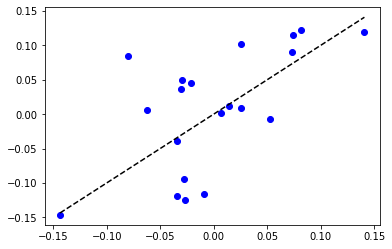

In [87]:
plt.plot(x, x_real, linestyle="None", marker="o", color="b")

plot_1_to_1_from_x(x=x)

plt.show()

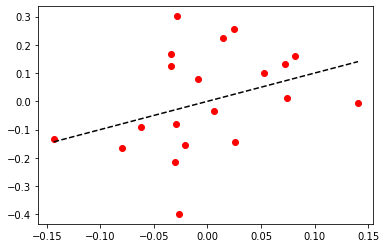

In [88]:
plt.plot(x, x_imag, linestyle="None", marker="o", color="r")

plot_1_to_1_from_x(x=x)

plt.show()

$\textbf{Matrix vs Pylops Formalism:}$

Let's compare the solutions we get from each of the following systems

$\left( \tilde{f_{\Re}}^T \tilde{f_{\Re}} \right) x_{\Re} = \tilde{f_{\Re}}^T y_{\Re}$

$\left( \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right) x_{\Im} = \tilde{f_{\Im}}^T y_{\Im}$

with the $\textbf{"wrong"}$ solution we get with the pylops (current) formalism from solving

$\left[ \tilde{f_{\Re}}^T \tilde{f_{\Re}} + \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right] x = \tilde{f_{\Re}}^T y_{\Re} + \tilde{f_{\Im}}^T y_{\Im}$

which is complex.

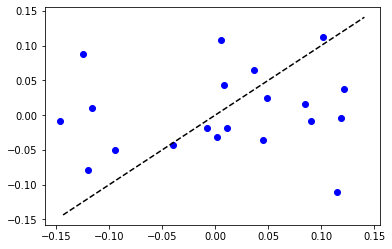

In [81]:
plt.plot(x_real, x_lops.real, linestyle="None", marker="o", color="b")

plot_1_to_1_from_x(x=x)

plt.show()

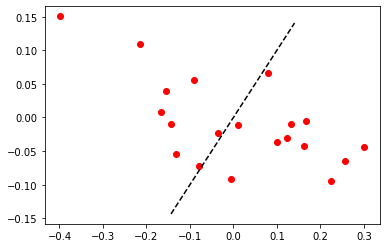

In [82]:
plt.plot(x_imag, x_lops.imag, linestyle="None", marker="o", color="r")

plot_1_to_1_from_x(x=x)

plt.show()

$\textbf{Matrix vs Pylops Formalism:}$

Let's compare the $\textbf{"true"}$ solution we get from solving the system

$\left[ \tilde{f_{\Re}}^T \tilde{f_{\Re}} + \tilde{f_{\Im}}^T \tilde{f_{\Im}} \right] x = \tilde{f_{\Re}}^T y_{\Re} + \tilde{f_{\Im}}^T y_{\Im}$


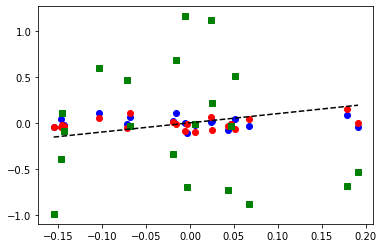

In [96]:
plt.figure()
plt.plot(x, x_lops.real, linestyle="None", marker="o", color="b")
plt.plot(x, x_lops.imag, linestyle="None", marker="o", color="r")
plt.plot(x, x_lops_with_real_and_imag_Ops, linestyle="None", marker="s", color="g")

plot_1_to_1_from_x(x=x)

plt.show()